In [1]:
import pandas as pd
import numpy as np
from queue import Queue
import threading
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from visualisation import label_barchart

from tabu_search import TabuSearchAlgorithm


def load_data(n=None):
    
    def cut(X, filter_values, log=False):
        if log: 
            X = np.log2(X)
        X_cut = pd.cut(X, bins=filter_values)
        X_cut = X_cut.map(lambda x: np.argmax(filter_values > x.left) - 1)
        X_cut.loc[X_cut.isnull()] = (
            X[X_cut.isnull()].map(lambda x: len(filter_values) - 2 if x > filter_values[-1] else 0)
        )
        return X_cut
    
    data2014 = pd.read_csv('data/data2014.csv').assign(year=2014)
    data2015 = pd.read_csv('data/data2015.csv').assign(year=2015)
    data = pd.concat([data2014, data2015], axis=0).reset_index(drop=True)

    target_name = "lmultiplier"
    bins = np.array([-2., 0., .3, 2])
    
    train_cols = [
        'LotNr', 'Allocate', 'Bank', 'Dealer', 'Liquidator', 'Volunteer', 
        'LotsSale', 'LotsCtgry', 'Forced', 'lEstValue', 'lFollowers', 
        'Duration', 'Morning', 'Evening', 'Afternoon', 'lSP.EV'
    ]
    
    log_cols = ["multiplier", "EstValue", "StartPrice", "SP.EV", "Followers"]
    log10 = pd.DataFrame(np.log10(data[log_cols].values), columns=list(map("l{}".format, log_cols)))
    data = pd.concat([data, log10], axis=1).drop(log_cols, axis=1)
    if n is not None:
        data = data.sample(n)
    X, y = data[train_cols], cut(data["lmultiplier"], bins)
    return X, y

def import_model(model_name):
    with open(model_name, 'rb') as f:
        model = pickle.load(f)
    return model

def optimise(row):
    params = dict(n_iter=1000, tabu_size=10, tolerance=.01, early_stop=5, verbose=False)
    tabu = TabuSearchAlgorithm(row, "output/AdaBoostClassifier.pkl", **params)
    tabu.solve()
    return tabu.best[1]

def make_optimisation(data):
    n_threads = 12
    queue = Queue()
    lock = threading.Lock()
    results = pd.DataFrame().reindex_like(X)
    
    # Create worker threads
    def create_workers():
        for _ in range(n_threads):
            t = threading.Thread(target=work)
            t.daemon = True
            t.start()
            
    # Do the next job in the queue and add the output to the results
    def work():
        while True:
            idx, row = queue.get()
            new_row = optimise(row)
            with lock:
                results.loc[idx] = new_row
            queue.task_done()

    # Create the jobs
    def create_jobs():
        [queue.put(row) for row in X.iterrows()]

    create_workers()
    create_jobs()
    queue.join()

    return results

In [2]:
X, y = load_data(10)
X_optimised = make_optimisation(X)
model = import_model("output/AdaBoostClassifier.pkl")
y_optimised = model.predict(X_optimised)

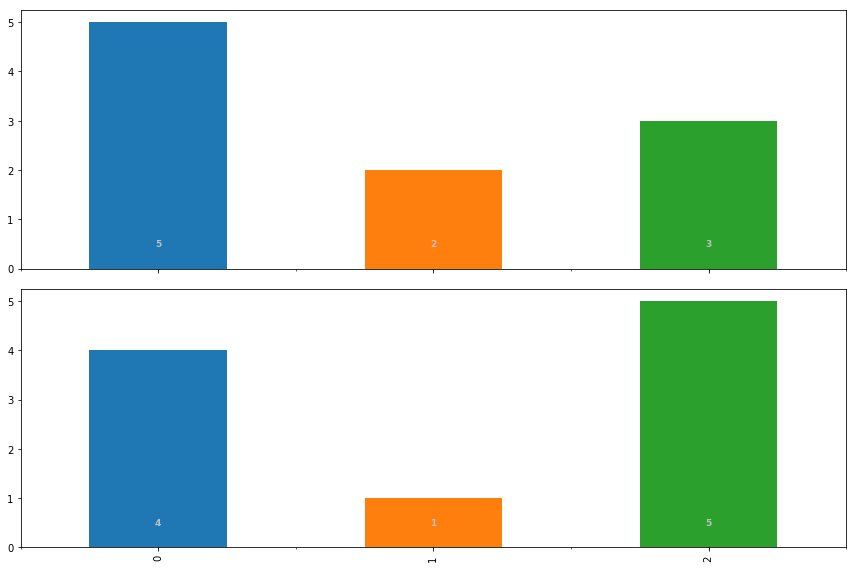

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
y.value_counts().sort_index().plot.bar(ax=ax1)
pd.Series(y_optimised).value_counts().sort_index().plot.bar(ax=ax2)
ax1.set_xlabel("")
label_barchart(ax1, fmt="{:.0f}")
label_barchart(ax2, fmt="{:.0f}")
plt.tight_layout()
plt.savefig("output/optimisation.png")